In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r /content/drive/My\ Drive/New\ Dataset /content/Dataset

In [81]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Model

import random as rn
import numpy as np

Set up tensorflow session.

In [6]:
np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)

Build classification model using VGG16.

In [72]:
def build_model():
  vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  for layer in vgg_model.layers:
      layer.trainable = True
  classification_model = keras.layers.Flatten(name="flatten")(vgg_model.output)
  classification_model = keras.layers.Dense(512, activation="relu")(classification_model)
  classification_model = keras.layers.Dropout(0.25)(classification_model)
  classification_model = keras.layers.Dense(3, activation="softmax")(classification_model)

  model = Model(inputs=vgg_model.input, outputs=classification_model)

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-4),
      loss=keras.losses.categorical_crossentropy,
      metrics=['accuracy'])
  
  return model

model = build_model()
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)     

In [77]:
SEED = 42
train_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255,
  rotation_range=45,           # apply rotations to augment data
  width_shift_range=0.2,       # horizontal shift
  height_shift_range=0.2,      # vertical shift
  horizontal_flip=True,        # image flips
  zoom_range=0.2,              # zoom
  brightness_range=[0.8,1.2],   # brightness
  fill_mode='nearest'
)
batchsize = 10
train_generator = train_datagen.flow_from_directory(
  directory = "/content/Dataset/train",
  target_size = (256, 256),
  batch_size = batchsize,
  shuffle = True,
  class_mode = 'categorical',
  seed=SEED
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
batchsize = 1
valid_generator = valid_datagen.flow_from_directory(
  directory = "/content/Dataset/validation",
  target_size = (256, 256),
  batch_size = batchsize,
  shuffle = False,
  class_mode = 'categorical'
)

Found 380 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [28]:
def get_class_weight():
  bathroom = 133
  bedroom = 134
  kitchen = 113
  total = bathroom + bedroom + kitchen
  class_weight = {0: total / bathroom, 1: total / bedroom, 2: total / kitchen}
  return class_weight

In [78]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg_{epoch:03d}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_freq='epoch')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

training = model.fit(
  train_generator,
  class_weight=get_class_weight(),
  epochs=100,
  validation_data=valid_generator,
  callbacks=[checkpoint, early_stopping],
  verbose=1,
)

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 1.3475 - accuracy: 0.8342
Epoch 00001: val_accuracy improved from -inf to 0.73016, saving model to vgg_001.h5
38/38 [==============================] - 14s 365ms/step - loss: 1.3475 - accuracy: 0.8342 - val_loss: 18.0645 - val_accuracy: 0.7302
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 1.6837 - accuracy: 0.7789
Epoch 00002: val_accuracy did not improve from 0.73016
38/38 [==============================] - 13s 345ms/step - loss: 1.6837 - accuracy: 0.7789 - val_loss: 5.5290 - val_accuracy: 0.7302
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 1.5838 - accuracy: 0.7868
Epoch 00003: val_accuracy did not improve from 0.73016
38/38 [==============================] - 13s 344ms/step - loss: 1.5838 - accuracy: 0.7868 - val_loss: 36.9721 - val_accuracy: 0.7143
Epoch 4/100
38/38 [==============================] - ETA: 0s - loss: 1.2160 - accuracy: 0.8632
Epoch 00004: val_accuracy im

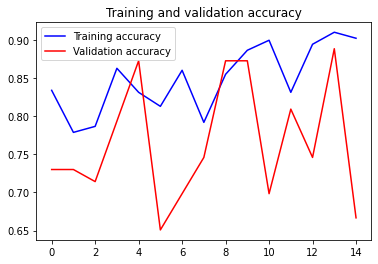

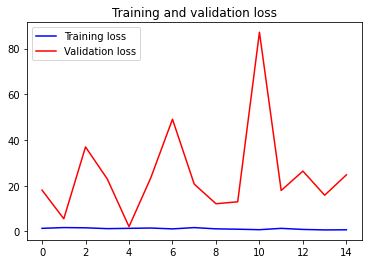

In [79]:
accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [84]:
tsdata = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = tsdata.flow_from_directory(
  directory="/content/Dataset/test",
  target_size=(256, 256),
  shuffle=False,
  batch_size=1,
  seed=42
)

model = load_model('vgg_014.h5')

results = model.evaluate(test_generator)
print(results)
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))
print(confusion_matrix(test_generator.classes, predictions))

Found 82 images belonging to 3 classes.
82/82 [==============================] - 1s 18ms/step - loss: 7.0146 - accuracy: 0.9146
[7.0146002769470215, 0.9146341681480408]
              precision    recall  f1-score   support

    Bathroom       0.96      0.88      0.92        25
     Bedroom       0.97      0.92      0.94        37
     Kitchen       0.79      0.95      0.86        20

    accuracy                           0.91        82
   macro avg       0.91      0.92      0.91        82
weighted avg       0.92      0.91      0.92        82

[[22  1  2]
 [ 0 34  3]
 [ 1  0 19]]
